In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from ccdproc import CCDData, trim_image, subtract_bias, subtract_dark, flat_correct, Combiner

import astropy.units as u
from astropy.visualization import simple_norm, ImageNormalize, ZScaleInterval

import warnings
warnings.simplefilter("ignore")

import glob
import os
from scipy.signal import medfilt

from photutils import aperture_photometry, DAOStarFinder, CircularAperture, CircularAnnulus
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch

from astropy.modeling.models import Moffat1D

In [34]:
def filter_fn(images):
    V = []
    for file in images:
        x = file.header['filter']
        if x == 'V':
            V.append(file)
    return V

def masterflat_fn(flat, flattype, filt):
    flats = Combiner(flat)
    master_flat = flats.median_combine()
    master_flat.header = flat[0].header
    master_flat.header['Combined'] = f'Combined {flattype} flats'
    master_flat.header['filter'] = f'{filt}'
    return master_flat
    
def flatcorrect_fn(images, flattype):
    i = []
    for file in images:
        x = file.header['filter']
        if x == 'V':
            flatcorrected = flat_correct(file, flattype)
            flatcorrected.data = flatcorrected.data / flatcorrected.header['EXPTIME']
            flatcorrected.unit = flatcorrected.unit / u.s
            i.append(flatcorrected)
        else:
            continue
    return i

# need to combine skyflats from same days
def date_fn(images):
    _08 = []
    _09 = []
    _11 = []
    for file in images:
        date = file.header['date-obs']
        if '-08T' in date:
            _08.append(file)
        elif '-09T' in date:
            _09.append(file)
        elif '-11T' in date:
            _11.append(file)
        else:
            continue
    return _08, _09, _11

## Read in data

In [35]:
# data
# g9348 (standard star)
g9348_loc = glob.glob('./data/07082022/G9348_V*.fits')
g9348 = []
for x in g9348_loc:
    image = CCDData.read(x, unit='adu')
    g9348.append(image)

# biases #
bias = []
bias_08 = glob.glob('./data/07082022/bias_*.fits')

for x in bias_08:
    image = CCDData.read(x, unit='adu')
    bias.append(image)
    
# sky flats
skyflats = []
skyflats_loc = glob.glob('./data/07082022/skyflats_10sec_V_*.fits')
skyflats_loc = [loc for loc in skyflats_loc if 'test' not in loc]

for x in skyflats_loc:
    image = CCDData.read(x, unit='adu')
    skyflats.append(image)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

### Removing Bias

In [36]:
biases = Combiner(bias)
master_bias = biases.median_combine()
master_bias.header = bias[0].header
master_bias.header['Combined'] = 'Combined with biases from 07 and 08'

In [37]:
# data bias subtraction
g9348_bias = []
for file in g9348:
    bias = subtract_bias(file, master_bias, add_keyword=True)
    g9348_bias.append(bias)

In [38]:
# sky flats bias subtraction
skyflats_bias = []
for file in skyflats:
    bias = subtract_bias(file, master_bias, add_keyword=True)
    skyflats_bias.append(bias)

### Master Flat

In [39]:
# sky master flats
skyflats_V = filter_fn(skyflats)

In [53]:
skyflats_V_08 = skyflats_V

skymasterflat_V_08 = masterflat_fn(skyflats_V_08, 'sky', 'V')

skymasterflats_08 = skymasterflat_V_08

In [43]:
# _, g9348_08, _ = date_fn(g9348_bias)
g9348_sky_08 = flatcorrect_fn(g9348_bias, skymasterflats_08)
g9348_sky = g9348_sky_08

# using G9348_V_60
sn_test = g9348_sky[4].data
mean, median, std = sigma_clipped_stats(g9348_sky[4], sigma=3.0)
znorm = ImageNormalize(stretch=SqrtStretch())

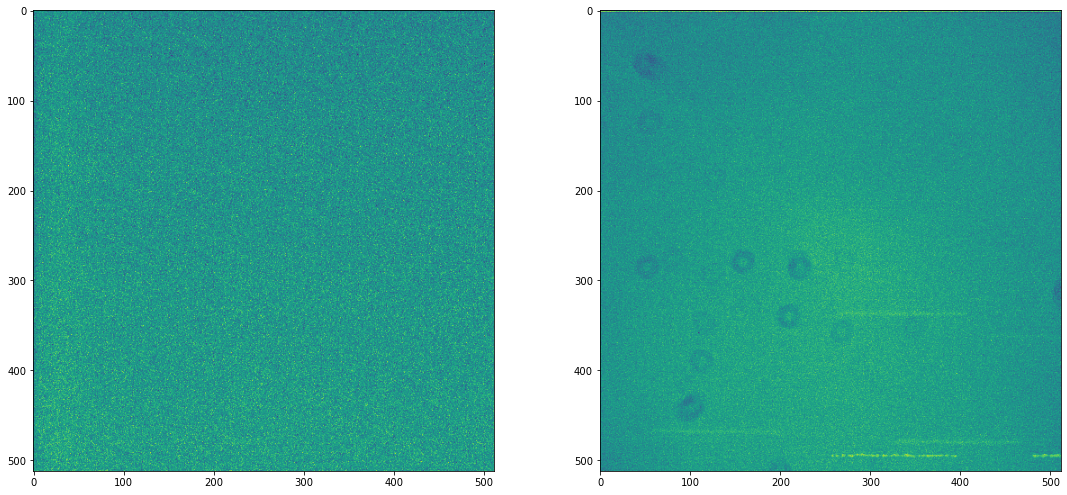

In [46]:
# 08
fig,ax = plt.subplots(1,2)
fig.set_size_inches(15, 15)
fig.tight_layout(w_pad=7.5, h_pad=5.5)

ax[0].imshow(master_bias);

ax[1].imshow(skymasterflat_V_08);

8.903613364043474


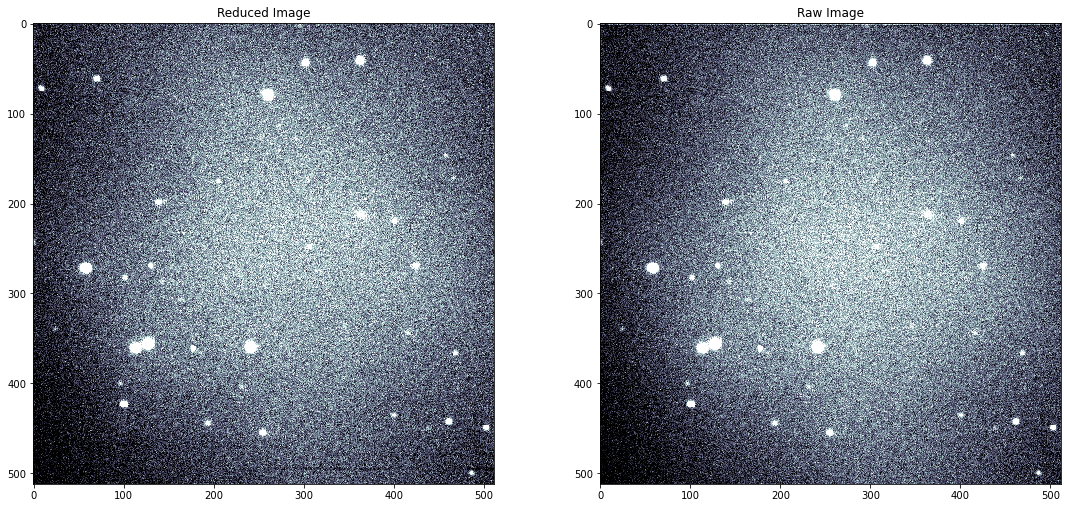

In [59]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(15, 15)
fig.tight_layout(w_pad=7.5, h_pad=5.5)

ax[1].imshow(g9348[4], vmin=np.percentile(g9348[4], 5),
           vmax=np.percentile(g9348[4], 98), cmap='bone', interpolation='nearest');
ax[1].title.set_fontsize(20)
ax[1].set_title('Raw Image');

ax[0].imshow(sn_test, vmin=np.percentile(sn_test, 5), 
           vmax=np.percentile(sn_test, 98), cmap='bone', interpolation='nearest');
ax[0].title.set_fontsize(20)
ax[0].set_title('Reduced Image');
print(np.mean(sn_test))

In [55]:
annulus_r_in = 21.8
annulus_r_out = 30.52
sciimg = sn_test
sciimg_data = np.ma.getdata(sciimg)

 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 260.63335569060536 ... 1.3927442348242827  -0.3596784235023982
  2 58.107153418705636 ... 1.4910525897642728 -0.43373240347092923
  3 127.39777740027951 ...  1.803850313059602  -0.6405012402911293
  4  241.5085112363741 ... 1.3290034320844513 -0.30881525621953504
  5 113.66684577462176 ... 1.1697329121407107 -0.17021677396979434


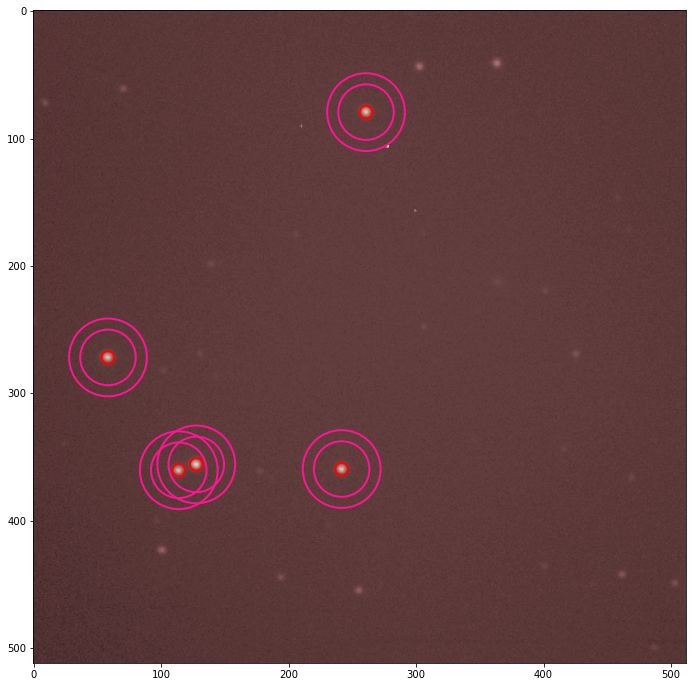

In [51]:
dao = DAOStarFinder(fwhm=2.18, threshold=100*std)
sources = dao(sciimg_data - median)
print(sources)

positions = []
for x, y in zip(sources['xcentroid'], sources['ycentroid']):
    points = [x, y]
    positions.append(points)
    
aperture_best = CircularAperture(positions, r=5)
annulus = CircularAnnulus(positions, r_in=annulus_r_in, r_out=annulus_r_out)

# Plotting apertures is easy with photutils aperture objects: just add .plot
plt.figure(figsize = (12,12))
plt.imshow(sn_test,norm=znorm,cmap='pink')
aperture_best.plot(color='red', linewidth=2)
annulus.plot(color='deeppink', linewidth=2)

total_sky = aperture_photometry(sn_test, annulus)['aperture_sum']
avg_sky = total_sky / annulus.area
sky = avg_sky * aperture_best.area
fluxes = sources['flux'].data - sky.data

In [52]:
print(fluxes)

[-716.90158612 -678.37116576 -698.33242995 -719.52740866 -692.30029139]
